In [1]:
import pandas as pd
from datasets import load_metric
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import os
import glob
from transformers import AutoTokenizer, AutoModel
import torch
from scipy.spatial.distance import cosine
import numpy as np

# Rouge Scores

In [2]:
rouge = load_metric("rouge")
df = pd.read_csv('T5_predictions.csv')
rouge_scores_dict = {}
scores = rouge.compute(predictions=df['Reference'].tolist(), 
                       references=df['Prediction'].tolist())
rouge_scores_dict['Long T5'] = scores

df = pd.read_csv('longformer_predictions.csv')
scores = rouge.compute(predictions=df['Reference'].tolist(), 
                       references=df['Prediction'].tolist())
rouge_scores_dict['Longformer'] = scores

df = pd.read_csv('mistral_parenthetical_predictions.csv')
scores = rouge.compute(predictions=df['Reference'].tolist(), 
                       references=df['Prediction'].tolist())
rouge_scores_dict['Mistral'] = scores

df = pd.read_csv('llama2_predictions.csv')
scores = rouge.compute(predictions=df['Reference'].tolist(), 
                       references=df['Prediction'].tolist())
rouge_scores_dict['Llama2'] = scores

rouge_scores_df = pd.DataFrame.from_dict(rouge_scores_dict, orient='index')

/tmp/ipykernel_60/2756149997.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")


In [3]:
rouge_scores_df

,rouge1,rouge2,rougeL,rougeLsum
Long T5,"((0.20461002236937603, 0.23114654322330316, 0....","((0.0484333893501774, 0.054848667318629966, 0....","((0.17999968350222714, 0.20047410684067896, 0....","((0.17972773662257735, 0.20036742191063403, 0...."
Longformer,"((0.19721174400621783, 0.20870384063247638, 0....","((0.04441007064516148, 0.04745767347000426, 0....","((0.17384776239090635, 0.182799044692542, 0.16...","((0.17365069823575627, 0.18300580606059602, 0...."
Mistral,"((0.3071234119954266, 0.152798046938877, 0.182...","((0.06641099029939225, 0.031608142171992135, 0...","((0.23689780809785374, 0.11731602474922906, 0....","((0.23831291226608878, 0.11747423181716628, 0...."
Llama2,"((0.2731972593775498, 0.15224571900607933, 0.1...","((0.05848068860230982, 0.030653097961316288, 0...","((0.2204041858934354, 0.12498415722499194, 0.1...","((0.22825222051371338, 0.12734759412604488, 0...."


In [4]:
rouge_scores_list = []

rouge = load_metric("rouge")

models = {
    'Long T5': 'T5_predictions.csv',
    'Longformer': 'longformer_predictions.csv',
    'Mistral': 'mistral_parenthetical_predictions.csv',
    'Llama2': 'llama2_predictions.csv'
}

for model_name, prediction_file in models.items():
    df = pd.read_csv(prediction_file)
    scores = rouge.compute(predictions=df['Prediction'].tolist(), 
                           references=df['Reference'].tolist())

    # START: Used GPT-4 to debug
    # Flatten the scores and format them
    for score_type, aggregate_score in scores.items():
        for confidence in ['low', 'mid', 'high']:
            score = getattr(aggregate_score, confidence)
            rouge_scores_list.append({
                'Model': model_name,
                'Score Type': score_type,
                'Confidence': confidence,
                'Precision': score.precision,
                'Recall': score.recall,
                'Fmeasure': score.fmeasure
            })
    # END: Used GPT-4 to debug
            
rouge_scores_df = pd.DataFrame(rouge_scores_list)
rouge_scores_df.set_index(['Model', 'Score Type', 'Confidence'], inplace=True)

print(rouge_scores_df)

                                  Precision    Recall  Fmeasure
Model      Score Type Confidence                               
Long T5    rouge1     low          0.231147  0.204610  0.199806
                      mid          0.235180  0.207610  0.202520
                      high         0.239340  0.210460  0.205022
           rouge2     low          0.054849  0.048433  0.047056
                      mid          0.056263  0.049750  0.048077
                      high         0.057807  0.051121  0.049288
           rougeL     low          0.200474  0.180000  0.174169
                      mid          0.203700  0.182355  0.176376
                      high         0.206886  0.184949  0.178464
           rougeLsum  low          0.200367  0.179728  0.174239
                      mid          0.203698  0.182403  0.176321
                      high         0.206877  0.184860  0.178302
Longformer rouge1     low          0.208704  0.197212  0.187740
                      mid          0.211

In [16]:
# Basically just copying the same cell some above and getting only the mid-confidence scores

rouge_scores_list = []

rouge = load_metric("rouge")

models = {
    'Long T5': 'T5_predictions.csv',
    'Longformer': 'longformer_predictions.csv',
    'Mistral': 'mistral_parenthetical_predictions.csv',
    'Llama2': 'llama2_predictions.csv'
}

for model_name, prediction_file in models.items():
    df = pd.read_csv(prediction_file)
    scores = rouge.compute(predictions=df['Prediction'].tolist(), 
                           references=df['Reference'].tolist())
    for score_type, aggregate_score in scores.items():
        for confidence in ['mid']:
            score = getattr(aggregate_score, confidence)
            rouge_scores_list.append({
                'Model': model_name,
                'Score Type': score_type,
                'Confidence': confidence,
                'Precision': score.precision,
                'Recall': score.recall,
                'Fmeasure': score.fmeasure
            })

rouge_scores_df_mid = pd.DataFrame(rouge_scores_list)
rouge_scores_df_mid.set_index(['Model', 'Score Type', 'Confidence'], inplace=True)

rouge_scores_df_mid = rouge_scores_df_mid.reset_index()
rouge_scores_df_mid.reset_index(drop=True, inplace=True)

rouge_scores_df_mid.columns = ['Comparison', 'Score Type', 'Confidence', 'Precision', 'Recall', 'Fmeasure']

rouge_scores_df_mid.to_csv("CaseHold_Parentheticals_Rouge_Score_mid_confidence_only.csv", index=False)

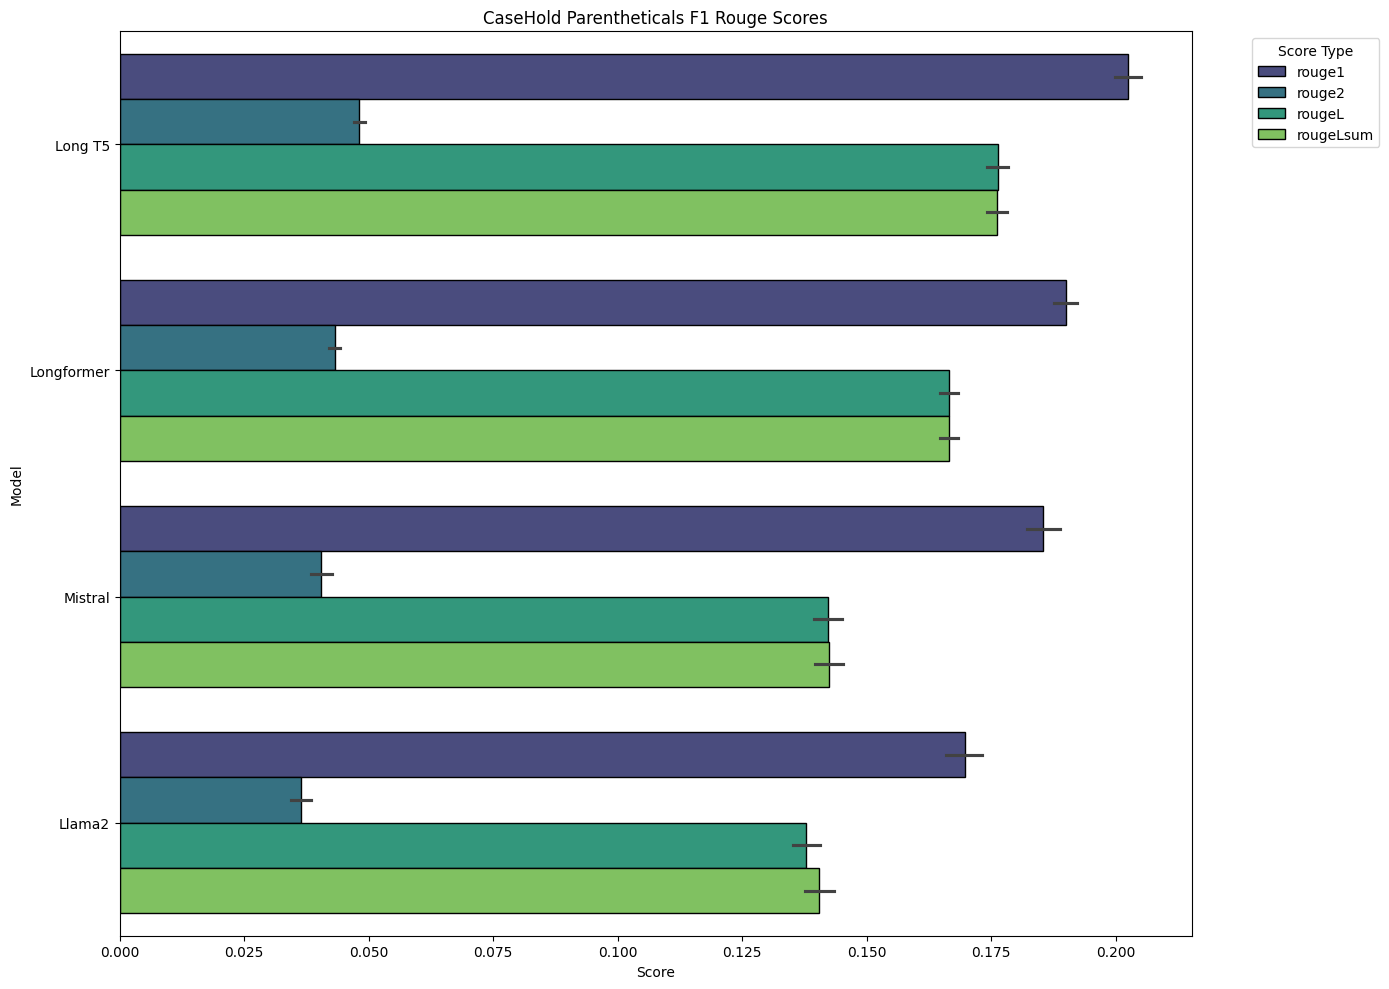

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

long_df = rouge_scores_df.reset_index().melt(id_vars=['Model', 'Score Type', 'Confidence'], 
                                             var_name='Metric', value_name='Score')
long_df = long_df[long_df['Metric'] == 'Fmeasure']

plt.figure(figsize=(14, 10))
sns.barplot(data=long_df, y='Model', x='Score', hue='Score Type', edgecolor='black', palette='viridis', orient='h')

plt.title('CaseHold Parentheticals F1 Rouge Scores')
plt.xlabel('Score')
plt.ylabel('Model')
plt.legend(title='Score Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('parenthetical_f1_rouge_scores_chart_horizontal.png', dpi=300)
plt.show()

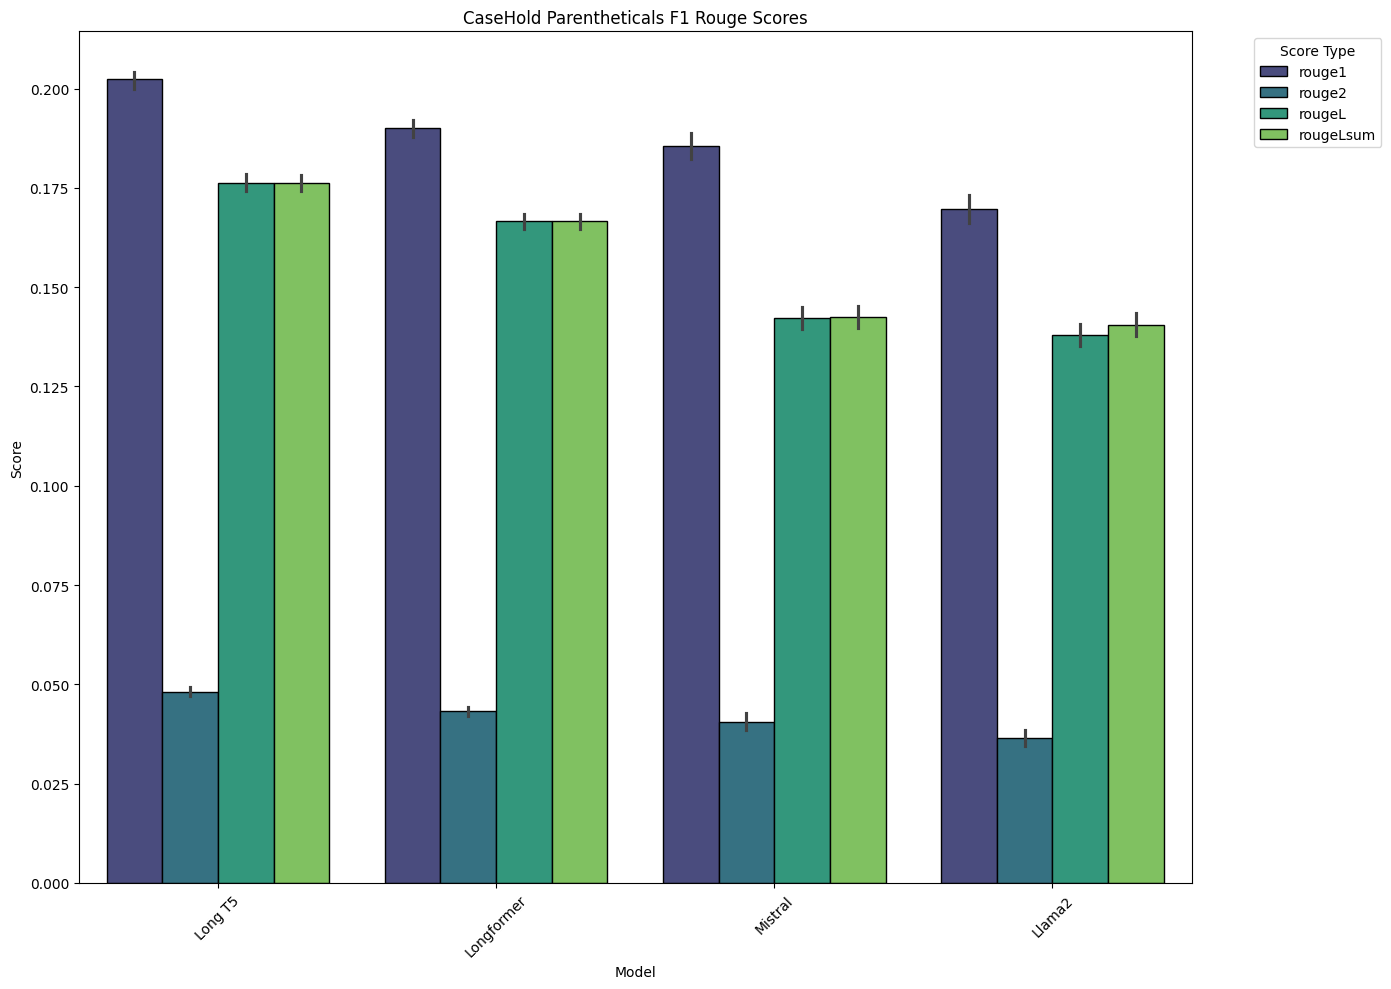

In [13]:
# Doing the same plot, but just flipped vertically
long_df = rouge_scores_df.reset_index().melt(id_vars=['Model', 'Score Type', 'Confidence'], 
                                             var_name='Metric', value_name='Score')
long_df = long_df[long_df['Metric'] == 'Fmeasure']

plt.figure(figsize=(14, 10))
sns.barplot(data=long_df, x='Model', y='Score', hue='Score Type', edgecolor='black', palette='viridis')

plt.title('CaseHold Parentheticals F1 Rouge Scores')
plt.xticks(rotation=45)
plt.legend(title='Score Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('parenthetical_f1_rouge_scores_chart_vertical.png', dpi=300)
plt.show()

In [27]:
torch.cuda.empty_cache()
gc.collect()

168

# BERT Scores

In [28]:
model_name = './legal-bert-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(32000, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inpl

In [31]:
# The functions below are used to get a BERT score dataframe

def get_embeddings(text_list, model, tokenizer, batch_size=512):
    model.eval()
    all_embeddings = []

    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i+batch_size]
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, max_length = 512, return_tensors='pt').to(device)

        with torch.no_grad():
            model_output = model(**encoded_input)

        # START: Copied from GPT-4
        embeddings = model_output.last_hidden_state
        attention_mask = encoded_input['attention_mask']
        mask_expanded = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
        sum_embeddings = torch.sum(embeddings * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        mean_pooled_embeddings = sum_embeddings / sum_mask

        all_embeddings.extend(mean_pooled_embeddings.cpu().numpy())
        # END: Copied from GPT-4

        # Clear up some memory
        del encoded_input, model_output, embeddings, attention_mask, mask_expanded, sum_embeddings, sum_mask, mean_pooled_embeddings
        torch.cuda.empty_cache()

    return np.array(all_embeddings)

def get_bert_scores_df(df, model, tokenizer):
    predictions = df['Prediction'].dropna().tolist()
    references = df['Reference'].dropna().tolist()

    pred_embeddings = get_embeddings(predictions, model, tokenizer)
    ref_embeddings = get_embeddings(references, model, tokenizer)

    bert_scores_list = []

    # START: Copied from GPT-4
    # Compute BERT scores as 1 - cosine distance
    bert_scores = [1 - cosine(pred, ref) for pred, ref in zip(pred_embeddings, ref_embeddings)]
    # END: Copied from GPT-4

    for idx, score in enumerate(bert_scores):
        bert_scores_list.append({
            'BERTScore': score
        })

    bert_scores_df = pd.DataFrame(bert_scores_list)

    return bert_scores_df

## If running on all of the predictions, the BERT scores can take 2 hours and up to 40 Gb of VRAM

In [32]:
df1 = pd.read_csv('T5_predictions.csv')
bert_scores_df1 = get_bert_scores_df(df1, model, tokenizer)

df2 = pd.read_csv('longformer_predictions.csv')
bert_scores_df2 = get_bert_scores_df(df2, model, tokenizer)

df3 = pd.read_csv('mistral_parenthetical_predictions.csv')
bert_scores_df3 = get_bert_scores_df(df3, model, tokenizer)

df4 = pd.read_csv('llama2_predictions.csv')
bert_scores_df4 = get_bert_scores_df(df4, model, tokenizer)

In [33]:
bert_scores_df1

,BERTScore
0,0.612261
1,0.589456
2,0.704552
3,0.626510
4,0.689526
...,...
3547,0.498301
3548,0.625253
3549,0.649482
3550,0.577546


In [34]:
torch.cuda.empty_cache()
gc.collect()

0

In [35]:
# Rename the BERT score column in each DataFrame
bert_scores_df1.rename(columns={'BERTScore': 'BERTScore Long T5'}, inplace=True)
bert_scores_df2.rename(columns={'BERTScore': 'BERTScore Longformer'}, inplace=True)
bert_scores_df3.rename(columns={'BERTScore': 'BERTScore Mistral'}, inplace=True)
bert_scores_df4.rename(columns={'BERTScore': 'BERTScore Llama2'}, inplace=True)

concatenated_df = pd.concat([bert_scores_df1['BERTScore Long T5'], 
                             bert_scores_df2['BERTScore Longformer'],
                             bert_scores_df3['BERTScore Mistral'],
                             bert_scores_df4['BERTScore Llama2'],
                            ], axis=1)

In [36]:
concatenated_df

,BERTScore Long T5,BERTScore Longformer,BERTScore Mistral,BERTScore Llama2
0,0.612261,0.670646,0.803745,0.767816
1,0.589456,0.564087,0.702875,0.652429
2,0.704552,0.648060,0.815076,0.747029
3,0.626510,0.621999,0.754601,0.643346
4,0.689526,0.662050,0.747645,0.806377
...,...,...,...,...
3547,0.498301,0.603545,0.643181,NaN
3548,0.625253,0.604800,0.693739,NaN
3549,0.649482,0.602400,0.615731,NaN
3550,0.577546,0.567430,NaN,NaN


In [40]:
concatenated_df.to_csv('parenthetical_bert_concatenated_df.csv', index=False)

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def get_bertscore_plot(concatenated_df, tag):

    melted_df = pd.melt(concatenated_df, var_name='Model', value_name='BERTScore')
    print(melted_df)

    melted_df['Model'] = melted_df['Model'].str.replace('BERTScore ', '')
    print(melted_df)

    plt.figure(figsize=(10, 8))
    sns.boxplot(x='BERTScore', y='Model', data=melted_df, orient='h')
    plt.title(f'Distribution of BERTScores for {tag}')
    plt.xlabel('BERTScore')
    plt.ylabel('Model')
    plt.tight_layout()
    filename = tag + '_bertscore_box_plot.png'
    plt.savefig(filename, dpi=300)
    plt.show()

                   Model  BERTScore
0      BERTScore Long T5   0.612261
1      BERTScore Long T5   0.589456
2      BERTScore Long T5   0.704552
3      BERTScore Long T5   0.626510
4      BERTScore Long T5   0.689526
...                  ...        ...
14203   BERTScore Llama2        NaN
14204   BERTScore Llama2        NaN
14205   BERTScore Llama2        NaN
14206   BERTScore Llama2        NaN
14207   BERTScore Llama2        NaN

[14208 rows x 2 columns]
         Model  BERTScore
0      Long T5   0.612261
1      Long T5   0.589456
2      Long T5   0.704552
3      Long T5   0.626510
4      Long T5   0.689526
...        ...        ...
14203   Llama2        NaN
14204   Llama2        NaN
14205   Llama2        NaN
14206   Llama2        NaN
14207   Llama2        NaN

[14208 rows x 2 columns]


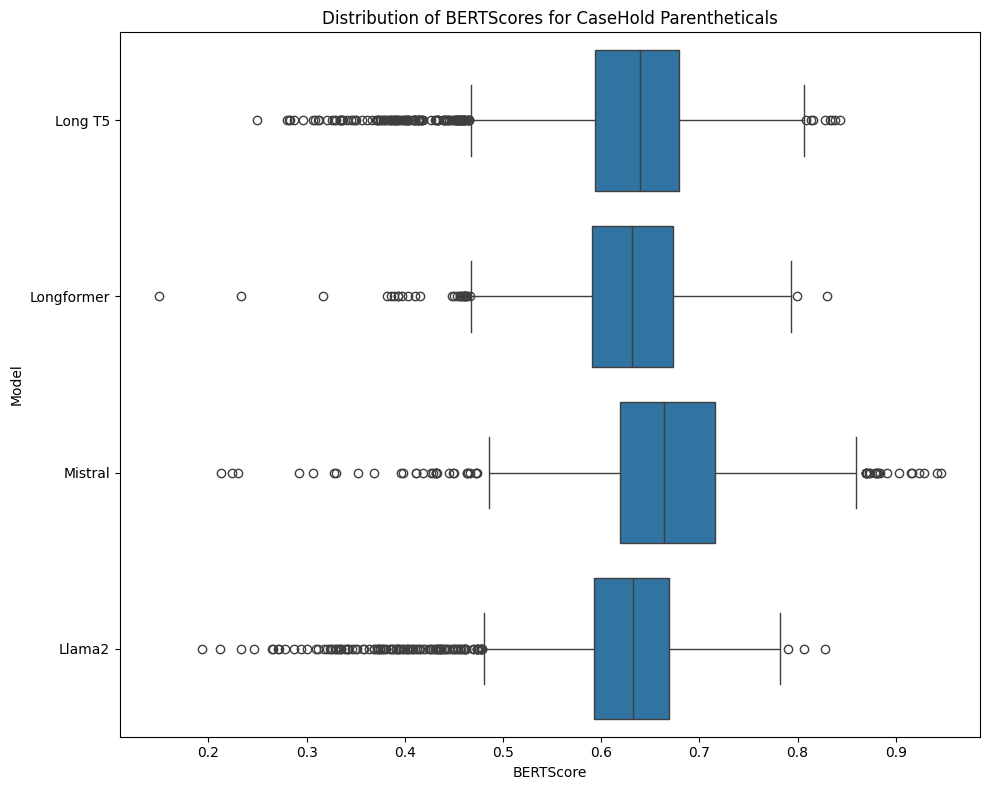

In [43]:
get_bertscore_plot(concatenated_df, 'CaseHold Parentheticals')

# Rouge and Bert scores for Holdings

In [111]:
import pandas as pd
import os
import glob
from datasets import load_metric

excel_file = 'reference_annotated_holdings_small.xlsx'
df = pd.read_excel(excel_file)

directories = ['ref_case_Claude2_zero_shot_holding_small',
               'ref_case_legalBertLarge_sum_llama_holdings_without_hint_small',
               'ref_case_llama_prompt_sum_llama_holdings_without_hint_small',
               'ref_case_llama_regular_sum_llama_holdings_without_hint_small',
               'ref_case_legalBertLarge_sum_Mistral_holdings_without_hint_small',
               'ref_case_llama_regular_sum_llama_holdings_small',
               'ref_case_llama_prompt_sum_llama_holdings_small',
               'ref_case_legalBertLarge_sum_llama_holdings_small',
               'ref_case_legalBertLarge_sum_Mistral_holdings_with_hint_small'
              ]

# This code was used to iterate through directories with holdings that were individiually in .txt files
data = {}

for directory in directories:

    txt_files = glob.glob(os.path.join(directory, '*.txt'))
    
    for txt_file in txt_files:
        case_num = os.path.basename(txt_file).split('_')[1]
        with open(txt_file, 'r') as file:
            content = file.read()
        match = df.loc[df['Case #'].astype(str) == case_num, 'Holding']
        
        if not match.empty:
            # Add the content to the data dictionary
            if case_num not in data:
                data[case_num] = {'Holding': match.iloc[0], directory: content}
            else:
                data[case_num][directory] = content

# Create a DataFrame with these holdings
content_df = pd.DataFrame.from_dict(data, orient='index').reset_index().rename(columns={'index': 'Case #'})

In [113]:
rename_dict = {'ref_case_Claude2_zero_shot_holding_small': 'Claude 2 zero-shot',
               'ref_case_legalBertLarge_sum_llama_holdings_without_hint_small': 'legalBertLarge_summary_llama_holdings_no_hint',
               'ref_case_llama_prompt_sum_llama_holdings_without_hint_small': 'llama_prompt_summary_llama_holdings_no_hint',
               'ref_case_llama_regular_sum_llama_holdings_without_hint_small': 'llama_regular_summary_llama_holdings_no_hint',
               'ref_case_legalBertLarge_sum_Mistral_holdings_without_hint_small': 'legalBertLarge_summary_Mistral_holdings_no_hint',
               'ref_case_llama_regular_sum_llama_holdings_small': 'llama_regular_summary_llama_holdings',
               'ref_case_llama_prompt_sum_llama_holdings_small': 'llama_prompt_summary_llama_holdings',
               'ref_case_legalBertLarge_sum_llama_holdings_small': 'legalBertLarge_summary_llama_holdings',
               'ref_case_legalBertLarge_sum_Mistral_holdings_with_hint_small': 'legalBertLarge_summary_Mistral_holdings'
                    }

In [46]:
content_df

,Case #,Holding,ref_case_Claude2_zero_shot_holding_small,ref_case_legalBertLarge_sum_llama_holdings_without_hint_small,ref_case_llama_prompt_sum_llama_holdings_without_hint_small,ref_case_llama_regular_sum_llama_holdings_without_hint_small,ref_case_legalBertLarge_sum_Mistral_holdings_without_hint_small,ref_case_llama_regular_sum_llama_holdings_small,ref_case_llama_prompt_sum_llama_holdings_small,ref_case_legalBertLarge_sum_llama_holdings_small,ref_case_legalBertLarge_sum_Mistral_holdings_with_hint_small
0,116,Where there is a question of whether and to wh...,Here is the concise holding for this case:\n\n...,"The holding in this case is:\n\n""In an actio...",The holding of the case is that the trial co...,"Holding: The failure to define the term ""pro...","In the given case, the trial court failed to ...",Holding: The trial court's failure to define...,The holding of the case is that it was error...,"The holding in this case is:\n\n""Proximate c...","In the given case document, the holding state..."
1,135,Where the state adduced no evidence of a purpo...,This case affirms the district court's denial ...,Holding: The trial court found that no bindi...,The holding in this case is that the univers...,Holding: The court held that the state canno...,The trial court found that no binding contrac...,The holding in this case is that the state c...,The holding in the case of 216 N. W. 250 is ...,Holding: The trial court found that no bindi...,"No binding contract was made, and the payment..."
2,146,Money from defendant's student loans that were...,Here is a concise holding based on the case do...,Holding: The trial court erred in ruling tha...,The holding of the case is:\n\nThe trial cou...,Holding: The court holds that depositing stu...,The trial court erred in ruling that Arata co...,The holding of the case is:\n\nHolding: The ...,The holding of the case is:\n\nStudent loan ...,The holding of the case is:\n\nHolding: Stud...,The trial court erred in ruling that Arata co...
3,175,HOLDING1: The prosecutor's repeated questions ...,The holding in this case is:\n\nThe appellant'...,Holding: The appellant's conviction for Firs...,The holding in this case is that the prosecu...,The holding of the case is as follows:\n\n* ...,The holding is that the appellant's convictio...,The holding in this case is that requesting ...,The holding in this case is:\n\nThe trial co...,The holding of the case is:\n\nThe appellant...,The case revolves around a defendant's appeal...
4,225,Where plaintiff adduced evidence that he was s...,Holding: The Commission erred in finding that ...,The holding in this case is that the Full Co...,The holding of the case is that the Full Com...,The holding in this case is that there was n...,The court held that the Commission's decision...,The holding in this case is that the South C...,The holding of the case is that the Full Com...,The holding of the case is that the Commissi...,The circuit court found substantial evidence ...
5,231,The dismissal of the suit filed by the plainti...,Here is a concise holding based on the case do...,The holding of the case is that the plaintif...,The holding of the case is that the lower co...,The holding of the case is as follows:\n\nTh...,The plaintiff alleges that the defendant scho...,The holding in this case is that the trial c...,The holding in this case is that the plainti...,The holding in this case is that the plainti...,"In this case, the plaintiff alleges that the ..."
6,235,A judgement for unpaid fees was a monetary jud...,Here is a concise holding for this case:\n\nTh...,The holding in this case is that the allowan...,The holding of the case can be summarized as...,The holding of the Michigan Court of Appeals...,The holding in this case is that the award of...,Holding: The court held that a claim for int...,The holding in this case is that the plainti...,The holding of the case is:\n\nThe allowance...,"The holding states that under §6013(1), the a..."
7,242,Where the insured's po

In [117]:
rouge_scores_dict = {}

rouge = load_metric("rouge")

for directory in directories:
    if directory in content_df.columns:
        scores = rouge.compute(predictions=content_df[directory].dropna().tolist(), references=content_df.loc[content_df[directory].dropna().index, 'Holding'].tolist())

        rouge_scores_dict[directory] = scores

rouge_scores_df = pd.DataFrame(rouge_scores_dict)

rouge_scores_df = rouge_scores_df.T

In [118]:
rouge_scores_df

,rouge1,rouge2,rougeL,rougeLsum
ref_case_Claude2_zero_shot_holding_small,"((0.24191831249315943, 0.4140289992573086, 0.3...","((0.0653903453093271, 0.1164945388230011, 0.08...","((0.15742329493060714, 0.2615346493533196, 0.1...","((0.1633093177480825, 0.27670852284405517, 0.2..."
ref_case_legalBertLarge_sum_llama_holdings_without_hint_small,"((0.16894357048558822, 0.4297009328002579, 0.2...","((0.03452113073489562, 0.08643500236065345, 0....","((0.10867842384851018, 0.2736265227095223, 0.1...","((0.11151909878723296, 0.2734963047193632, 0.1..."
ref_case_llama_prompt_sum_llama_holdings_without_hint_small,"((0.1648972422717385, 0.46584924083171536, 0.2...","((0.03948608933853066, 0.10060053223799832, 0....","((0.10977239614424791, 0.3070769645475883, 0.1...","((0.11448180850913958, 0.3180434075298106, 0.1..."
ref_case_llama_regular_sum_llama_holdings_without_hint_small,"((0.1593134549890168, 0.4917248127328111, 0.23...","((0.041862065559857234, 0.1279324883449002, 0....","((0.10535542316403135, 0.3155288489680281, 0.1...","((0.11262384239881838, 0.33896482206933065, 0...."
ref_case_legalBertLarge_sum_Mistral_holdings_without_hint_small,"((0.21635636399801172, 0.42237671658482473, 0....","((0.04432075272019538, 0.09443085843724755, 0....","((0.1382833958122822, 0.25994955140370235, 0.1...","((0.1388347888070534, 0.26068988380769803, 0.1..."
ref_case_llama_regular_sum_llama_holdings_small,"((0.18087902958840896, 0.4413693409107092, 0.2...","((0.047189270614916394, 0.12038635526824061, 0...","((0.11379312069000173, 0.27451649128057365, 0....","((0.12102060752599013, 0.29295439431594744, 0...."
ref_case_llama_prompt_sum_llama_holdings_small,"((0.14089020641604733, 0.4602022134132058, 0.2...","((0.03972879512528673, 0.12357002536531635, 0....","((0.09783914084249538, 0.3119466511963134, 0.1...","((0.09930351840256985, 0.3119308827426388, 0.1..."
ref_case_legalBertLarge_sum_llama_holdings_small,"((0.19959468285585177, 0.4312959140251446, 0.2...","((0.03935047324040707, 0.09265022026586676, 0....","((0.12517536611547342, 0.2665835126467893, 0.1...","((0.12890482953554458, 0.26771309505274504, 0...."
ref_case_legalBertLarge_sum_Mistral_holdings_with_hint_small,"((0.21606826252241104, 0.44111384036483114, 0....","((0.04385891139706076, 0.09024092806775644, 0....","((0.1340041538233147, 0.27074922461873374, 0.1...","((0.13441512030388467, 0.26980480994569245, 0...."


In [119]:
# As before, recreating the rouge score table but in a different view
rouge_scores_list = []

rouge = load_metric("rouge")

for directory in directories:
    if directory in content_df.columns:
        scores = rouge.compute(predictions=content_df[directory].dropna().tolist(),
                               references=content_df.loc[content_df[directory].dropna().index, 'Holding'].tolist())
        for score_type, aggregate_score in scores.items():
            for confidence in ['low', 'mid', 'high']:
                score = getattr(aggregate_score, confidence)
                rouge_scores_list.append({
                    'Directory': directory,
                    'Score Type': score_type,
                    'Confidence': confidence,
                    'Precision': score.precision,
                    'Recall': score.recall,
                    'Fmeasure': score.fmeasure
                })

rouge_scores_df = pd.DataFrame(rouge_scores_list)
rouge_scores_df.set_index(['Directory', 'Score Type', 'Confidence'], inplace=True)

print(rouge_scores_df)

                                                                          Precision  \
Directory                                          Score Type Confidence              
ref_case_Claude2_zero_shot_holding_small           rouge1     low          0.241918   
                                                              mid          0.282695   
                                                              high         0.320938   
                                                   rouge2     low          0.065390   
                                                              mid          0.086024   
...                                                                             ...   
ref_case_legalBertLarge_sum_Mistral_holdings_wi... rougeL     mid          0.164544   
                                                              high         0.203634   
                                                   rougeLsum  low          0.134415   
                                           

In [123]:
# As before, recreating the rouge score table but in a different view
rouge_scores_list = []

rouge = load_metric("rouge")

for directory in directories:
    if directory in content_df.columns:
        scores = rouge.compute(predictions=content_df[directory].dropna().tolist(),
                               references=content_df.loc[content_df[directory].dropna().index, 'Holding'].tolist())
        for score_type, aggregate_score in scores.items():
            for confidence in ['mid']:
                score = getattr(aggregate_score, confidence)
                rouge_scores_list.append({
                    'Directory': directory,
                    'Score Type': score_type,
                    'Confidence': confidence,
                    'Precision': score.precision,
                    'Recall': score.recall,
                    'Fmeasure': score.fmeasure
                })

rouge_scores_df_mid = pd.DataFrame(rouge_scores_list)
rouge_scores_df_mid.set_index(['Directory', 'Score Type', 'Confidence'], inplace=True)

rouge_scores_df_mid = rouge_scores_df_mid.reset_index()
rouge_scores_df_mid.reset_index(drop=True, inplace=True)

rouge_scores_df_mid.columns = ['Comparison', 'Score Type', 'Confidence', 'Precision', 'Recall', 'Fmeasure']
rouge_scores_df_mid['Comparison'].replace(rename_dict)
rouge_scores_df_mid.to_csv("Holding_Rouge_Score_mid_confidence_only.csv", index=False)

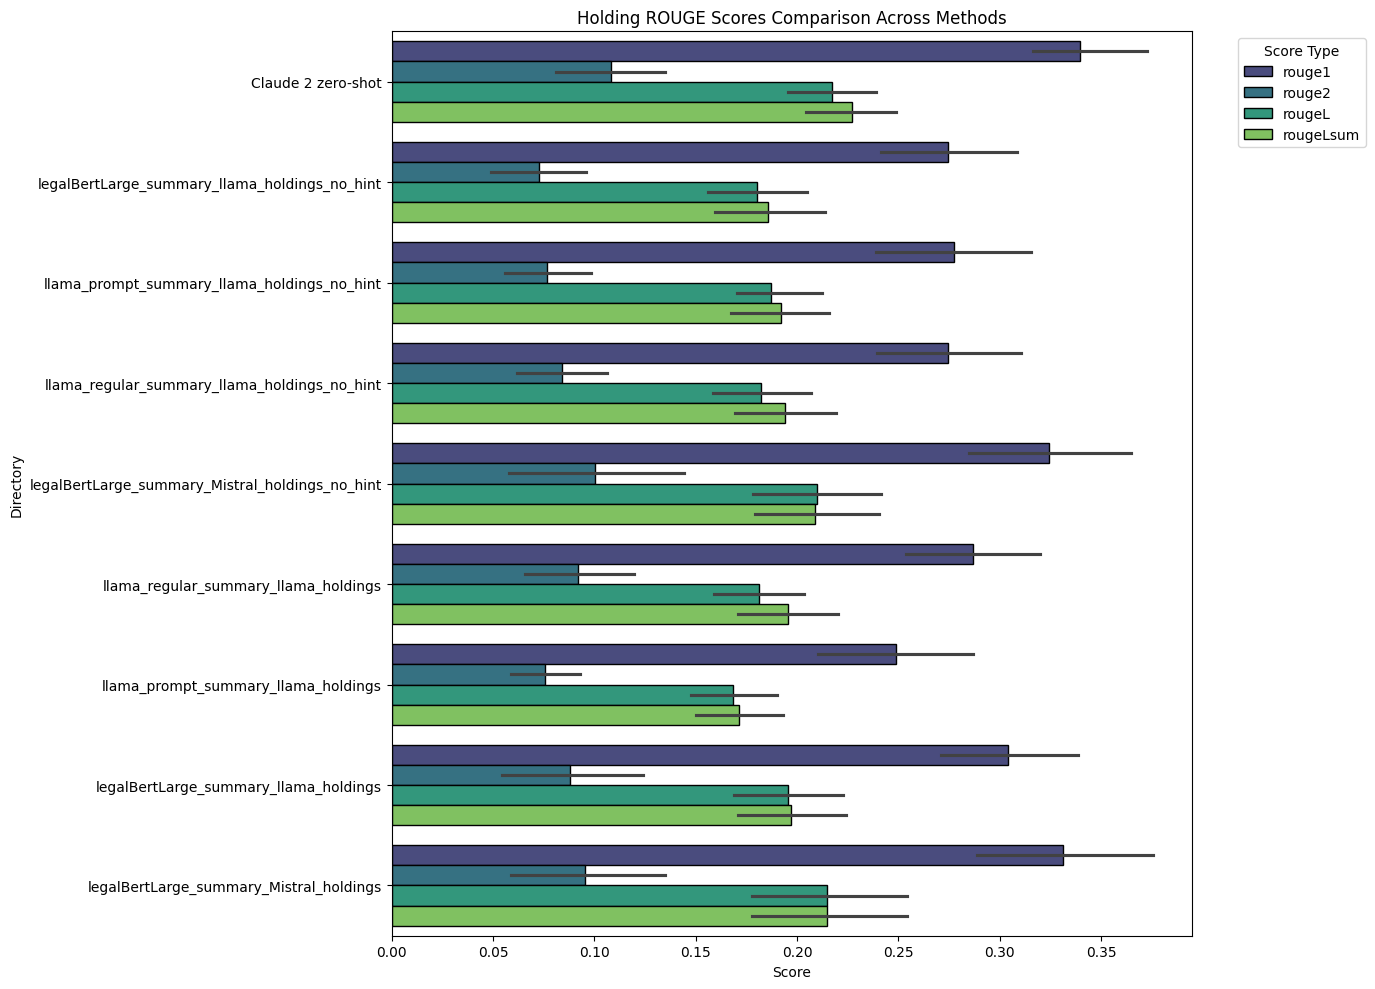

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

long_df = rouge_scores_df.reset_index().melt(id_vars=['Directory', 'Score Type', 'Confidence'], 
                                             var_name='Metric', value_name='Score')
long_df = long_df[long_df['Metric'] == 'Fmeasure']
long_df['Directory'] = long_df['Directory'].replace(rename_dict)

plt.figure(figsize=(14, 10))
sns.barplot(data=long_df, y='Directory', x='Score', hue='Score Type', edgecolor='black', palette='viridis', orient='h')

plt.title('Holding ROUGE Scores Comparison Across Methods')
plt.xlabel('Score')
plt.ylabel('Directory')
plt.legend(title='Score Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('holding_rouge_scores_chart_horizontal.png', dpi=300)
plt.show()

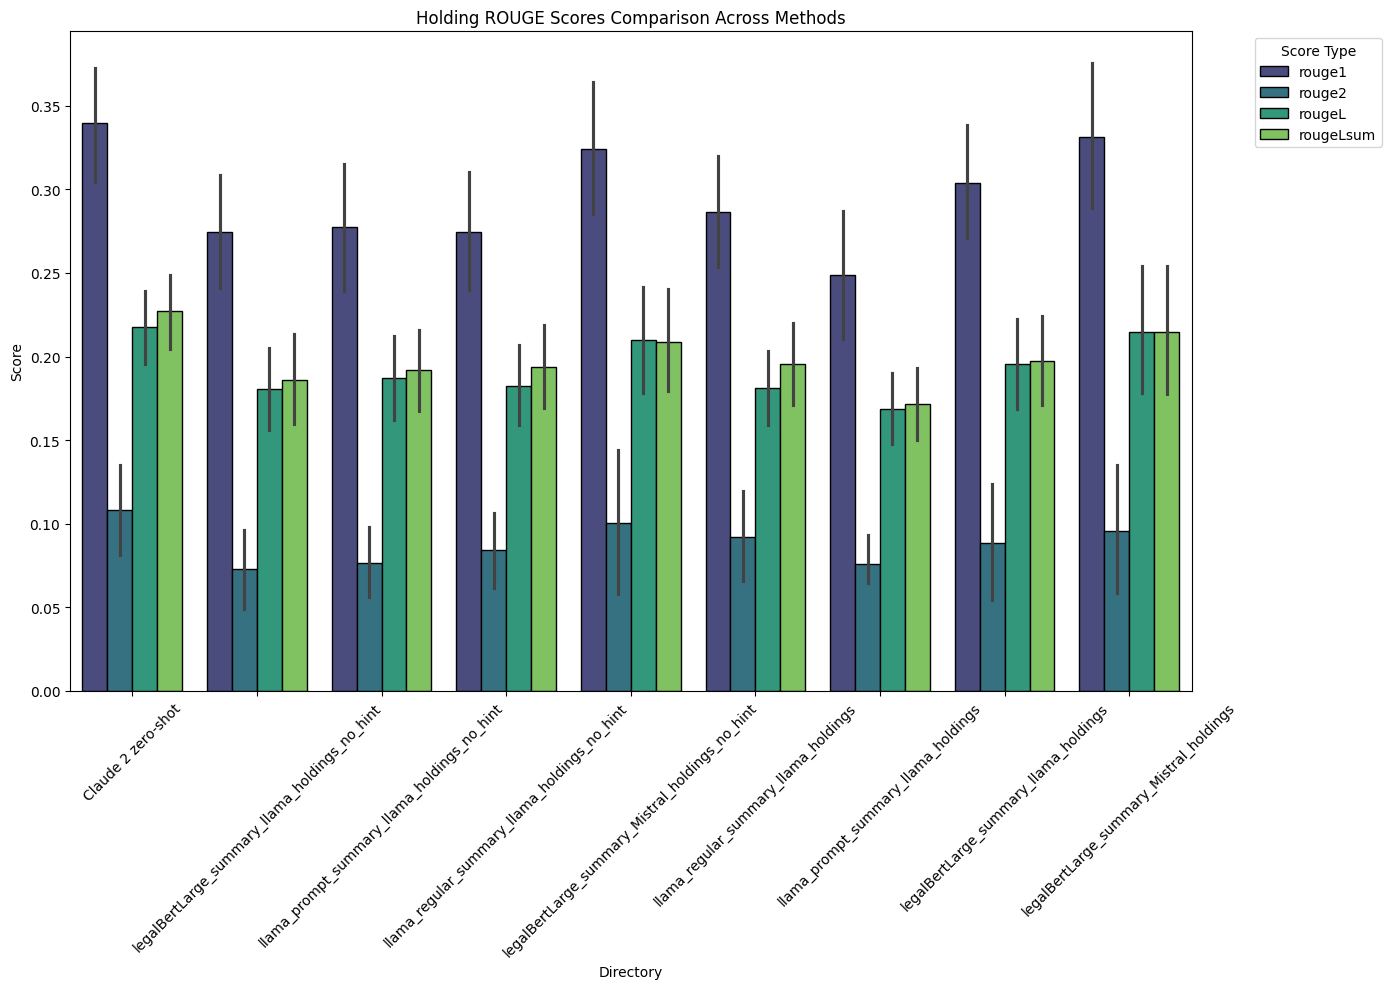

In [126]:
long_df = rouge_scores_df.reset_index().melt(id_vars=['Directory', 'Score Type', 'Confidence'], 
                                             var_name='Metric', value_name='Score')
long_df = long_df[long_df['Metric'] == 'Fmeasure']
long_df['Directory'] = long_df['Directory'].replace(rename_dict)
plt.figure(figsize=(14, 10))
sns.barplot(data=long_df, x='Directory', y='Score', hue='Score Type', edgecolor='black', palette='viridis')

plt.title('Holding ROUGE Scores Comparison Across Methods')
plt.xticks(rotation=45)
plt.legend(title='Score Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('holding_rouge_scores_chart_vertical.png', dpi=300)
plt.show()

In [127]:
import pandas as pd
import os
import glob
from transformers import AutoTokenizer, AutoModel
import torch
from scipy.spatial.distance import cosine

excel_file = 'reference_annotated_holdings_small.xlsx'
df = pd.read_excel(excel_file)

model_name = './legal-bert-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to calculate embeddings
def get_embeddings(text_list, model, tokenizer):
    encoded_input = tokenizer(text_list, padding=True, truncation=True, max_length=512, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = model(**encoded_input)
    embeddings = model_output.last_hidden_state
    attention_mask = encoded_input['attention_mask']
    mask_expanded = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    sum_embeddings = torch.sum(embeddings * mask_expanded, 1)
    sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
    mean_pooled_embeddings = sum_embeddings / sum_mask
    return mean_pooled_embeddings.cpu().numpy()

# Getting bert scores for all of the holdings by putting it into a dataframe from their respective directories
def get_bert_scores_df(directories, model, tokenizer):
    data = {}
    
    for directory in directories:
        
        txt_files = glob.glob(os.path.join(directory, '*.txt'))
        
        for txt_file in txt_files:
            case_num = os.path.basename(txt_file).split('_')[1]
            
            with open(txt_file, 'r') as file:
                content = file.read()
            
            match = df.loc[df['Case #'].astype(str) == case_num, 'Holding']
            
            if not match.empty:
                if case_num not in data:
                    data[case_num] = {'Holding': match.iloc[0], directory: content}
                else:
                    data[case_num][directory] = content
    
    content_df = pd.DataFrame.from_dict(data, orient='index').reset_index().rename(columns={'index': 'Case #'})

    bert_scores_list = []
    
    for directory in directories:
        if directory in content_df.columns:
            cands = content_df[directory].dropna().tolist()
            refs = content_df.loc[content_df[directory].dropna().index, 'Holding'].tolist()

            cand_embeddings = get_embeddings(cands, model, tokenizer)
            ref_embeddings = get_embeddings(refs, model, tokenizer)

            bert_scores = [1 - cosine(cand, ref) for cand, ref in zip(cand_embeddings, ref_embeddings)]

            for idx, score in enumerate(bert_scores):
                bert_scores_list.append({
                    'Directory': directory,
                    'Case #': content_df.loc[content_df[directory].dropna().index, 'Case #'].tolist()[idx],
                    'BERTScore': score
                })
    
    bert_scores_df = pd.DataFrame(bert_scores_list)
    
    return bert_scores_df

In [128]:
# List of directories for holdings
directories_for_holdings = ['ref_case_Claude2_zero_shot_holding_small',
               'ref_case_legalBertLarge_sum_llama_holdings_without_hint_small',
               'ref_case_llama_prompt_sum_llama_holdings_without_hint_small',
               'ref_case_legalBertLarge_sum_Mistral_holdings_without_hint_small',
               'ref_case_llama_regular_sum_llama_holdings_small',
               'ref_case_llama_prompt_sum_llama_holdings_small',
               'ref_case_legalBertLarge_sum_llama_holdings_small',
               'ref_case_legalBertLarge_sum_Mistral_holdings_with_hint_small'
              ]
bert_scores_df = get_bert_scores_df(directories_for_holdings, model, tokenizer)

In [133]:
bert_scores_df

,Directory,Case #,BERTScore
0,Claude 2 zero-shot,116,0.863246
1,Claude 2 zero-shot,135,0.810398
2,Claude 2 zero-shot,146,0.783714
3,Claude 2 zero-shot,175,0.855734
4,Claude 2 zero-shot,225,0.837826
...,...,...,...
115,legalBertLarge_summary_Mistral_holdings,284,0.845362
116,legalBertLarge_summary_Mistral_holdings,289,0.804230
117,legalBertLarge_summary_Mistral_holdings,316,0.830738
118,legalBertLarge_summary_Mistral_holdings,335,0.825772


In [132]:
bert_scores_df['Directory'] = bert_scores_df['Directory'].replace(rename_dict)

In [134]:
# Pivoting the bert_scores_df so that it can viewed more easily
pivot_df = bert_scores_df.pivot(index='Case #', columns='Directory', values='BERTScore').reset_index()

pivot_df.columns.name = None
pivot_df.columns = ['Case #'] + [f'BERTScore_{col}' for col in pivot_df.columns[1:]]

pivot_df.to_excel("holding bert scores.xlsx", index=False)

In [135]:
pivot_df

,Case #,BERTScore_Claude 2 zero-shot,BERTScore_legalBertLarge_summary_Mistral_holdings,BERTScore_legalBertLarge_summary_Mistral_holdings_no_hint,BERTScore_legalBertLarge_summary_llama_holdings,BERTScore_legalBertLarge_summary_llama_holdings_no_hint,BERTScore_llama_prompt_summary_llama_holdings,BERTScore_llama_prompt_summary_llama_holdings_no_hint,BERTScore_llama_regular_summary_llama_holdings
0,116,0.863246,0.891047,0.802626,0.815918,0.876225,0.824578,0.853377,0.806220
1,135,0.810398,0.815382,0.796819,0.813662,0.805767,0.781630,0.777343,0.766936
2,146,0.783714,0.799750,0.818922,0.826052,0.833013,0.797479,0.816530,0.714594
3,175,0.855734,0.867082,0.811534,0.836340,0.826962,0.839090,0.846183,0.817823
4,225,0.837826,0.847484,0.875071,0.846496,0.877769,0.842093,0.864887,0.875347
5,231,0.847863,0.822218,0.822593,0.804697,0.847832,0.817065,0.820867,0.829646
6,235,0.821042,0.841932,0.809364,0.793371,0.812757,0.784630,0.772603,0.714049
7,242,0.815283,0.849515,0.792911,0.780990,0.747975,0.783437,0.813710,0.794448
8,249,0.731250,0.783490,0.778563,0.742934,0.738791,0.690005,0.720741,0.730612
9,278,0.768467,0.744479,0.779234,0.788106,0.762768,0.781461,0.842219,0.813806


In [136]:
pivot_df.drop(columns="Case #")
pivot_df_stats = pivot_df.describe()
pivot_df_stats = pd.DataFrame(pivot_df_stats)
pivot_df_stats.to_excel("Holding_bert_stats.xlsx", index=True)

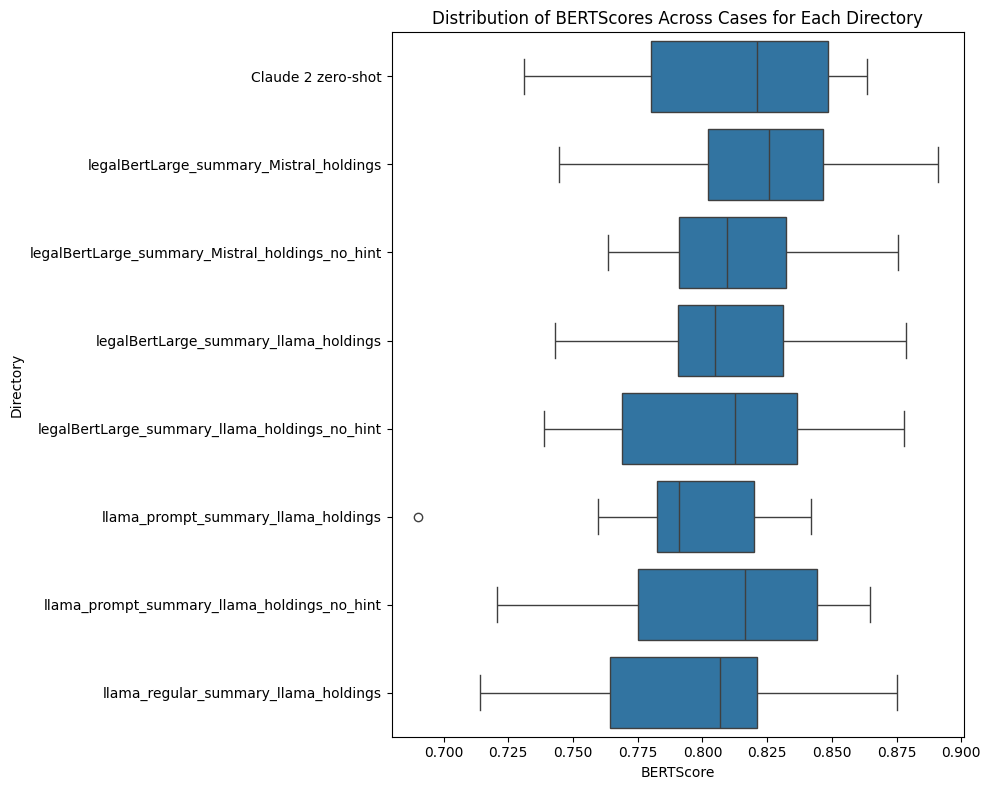

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

bert_score_columns = [col for col in pivot_df.columns if 'BERTScore' in col]
columns_to_melt = ['Case #'] + bert_score_columns

# Melt the DataFrame to have a long-form DataFrame with 'Case #' and 'BERTScore' as variables
melted_df = pd.melt(pivot_df[columns_to_melt], id_vars=['Case #'], var_name='Directory', value_name='BERTScore')

melted_df['Directory'] = melted_df['Directory'].str.replace('BERTScore_', '')

plt.figure(figsize=(10, 8))
sns.boxplot(x='BERTScore', y='Directory', data=melted_df, orient='h')
plt.title('Distribution of BERTScores Across Cases for Each Directory')
plt.xlabel('BERTScore')
plt.ylabel('Directory')
plt.tight_layout()
plt.savefig('holding_bert_scores_chart.png', dpi=300)
plt.show()

## Summac Score Plotting

In [ ]:
import pandas as pd
import os
import re

# Cleans in the score values of non-numericals
# probably not necessary but it looked like some of the numbers had apostrophes
def clean_and_convert_scores(score):
    if pd.isna(score):
        return None
    cleaned_score = re.sub(r'[^\d.]+', '', str(score))
    try:
        return float(cleaned_score)
    except ValueError:
        return None

# Takes in a list of csv files and returns a dataframe with all the scores data
def create_combined_scores_df(csv_files):
    all_data = pd.DataFrame()
    dataframes = []
    for file in os.listdir(csv_dir):
        if file in csv_files:
            file_path = os.path.join(csv_dir, file)
            df = pd.read_csv(file_path)
            df['Score'] = df['Score'].apply(clean_and_convert_scores)
            df = df.dropna(subset=['Score'])
            base_name = os.path.splitext(file)[0]
            df = df.rename(columns={'Score': f'{base_name}_Score'})
            dataframes.append(df[f'{base_name}_Score'])
    
    # Merge all DataFrames on 'ID'
    all_data = pd.concat(dataframes, axis=1).T.drop_duplicates().T
    return all_data

In [ ]:
csv_files = ['T5_summac_results.csv', 
             'longformer_summac_results.csv',
             'mistral_summac_results.csv',
             'llama2_summac_results.csv'
             ]
csv_dir = 'summac_and_bleurt'
summac_df = create_combined_scores_df(csv_files)

In [ ]:
summac_df

In [ ]:
summac_df_stats = summac_df.describe()
summac_df_stats = pd.DataFrame(summac_df_stats)
summac_df_stats.to_excel("Parenthetical_summac_stats.xlsx", index=True)

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=summac_df, orient='h', color=sns.color_palette()[0])
plt.title('Parenthetical Summac Scores')
plt.tight_layout()
plt.savefig('parenthical_summac_scores_plot.png', dpi=300)
plt.show()

In [ ]:
# Altered the above function to work for a list of .txt since that is what the bleurt scores were in
def create_combined_scores_df(txt_files, txt_dir):
    dataframes = []
    for file in os.listdir(txt_dir):
        if file in txt_files:
            file_path = os.path.join(txt_dir, file)
            with open(file_path, 'r') as f:
                scores = f.read().splitlines()

            cleaned_scores = [clean_and_convert_scores(score) for score in scores]
            cleaned_scores = [score for score in cleaned_scores if score is not None]

            base_name = os.path.splitext(file)[0]
            df = pd.DataFrame(cleaned_scores, columns=[f'{base_name}'])
            dataframes.append(df)

    all_data = pd.concat(dataframes, axis=1)

    return all_data

In [ ]:
txt_files = ['T5_bleurt_scores.txt', 
             'longformer_bleurt_scores.txt',
             'mistral_bleurt_scores.txt',
             'llama2_bleurt_scores.txt'
             ]
txt_dir = 'summac_and_bleurt'
bleurt_df = create_combined_scores_df(txt_files, txt_dir)

In [ ]:
bleurt_df

In [ ]:
bleurt_df_stats = bleurt_df.describe()
bleurt_df_stats = pd.DataFrame(bleurt_df_stats)
bleurt_df_stats.to_excel("Parenthetical_bleurt_stats.xlsx", index=True)

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=bleurt_df, orient='h', color=sns.color_palette()[0])
plt.title('Parenthetical Bleurt Scores')
plt.tight_layout()
plt.savefig('parenthical_bleurt_scores_plot.png', dpi=300)
plt.show()